In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [2]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [6]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [7]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_10 = df.iloc[:,9]
serie_10.head()

,#10
0,0.044965
1,0.044284
2,0.088023
3,0.001452
4,0.021937


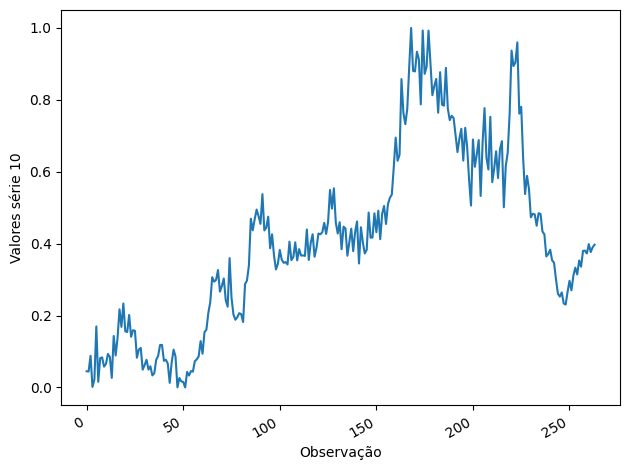

In [8]:
fig, ax = plt.subplots()

ax.plot(serie_10)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 10')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

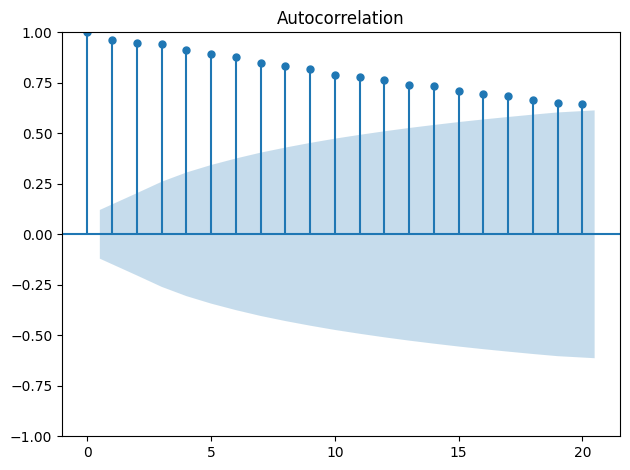

In [9]:
plot_acf(serie_10, lags=20);
plt.tight_layout()

In [10]:
advanced_decomposition = STL(serie_10,period=12).fit()

## Conjunto de treino

In [11]:
test = pd.DataFrame()
test["Values"] = serie_10.iloc[-12:]
test['naive_seasonal'] = serie_10.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_10.iloc[-24:-12].mean()

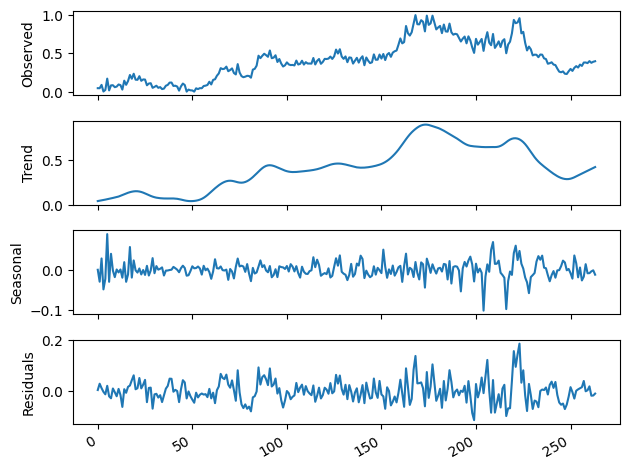

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [13]:
check_stationarity(serie_10,seasonal_period=12)

{'adf_stat': np.float64(-3.147990904973733),
 'p_value': np.float64(0.0231995455416266),
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 1}

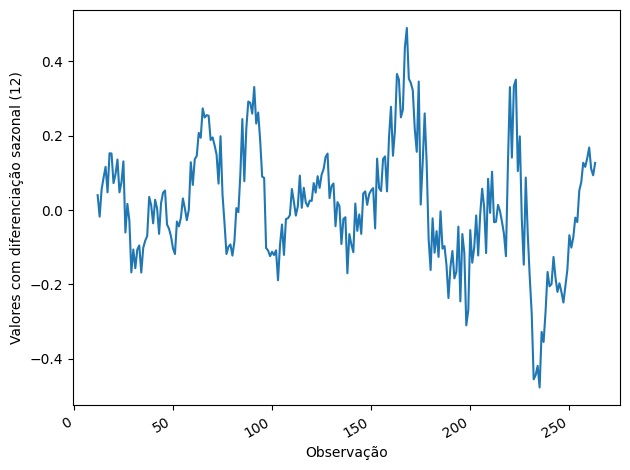

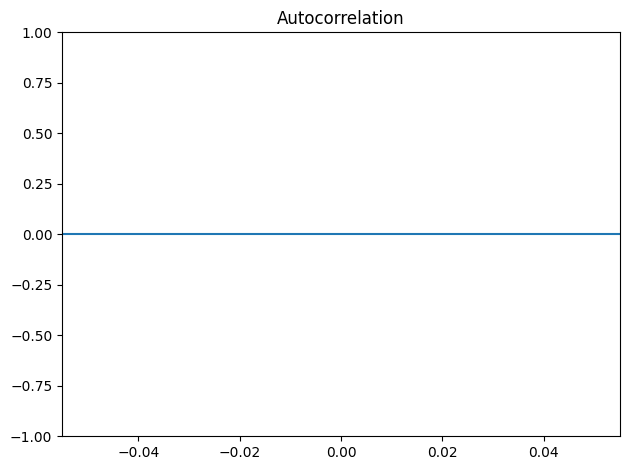

In [14]:
seasonal_diff = serie_10.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [15]:
train = serie_10[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(3,1,12) | AIC = -930.680839 \\
* SARIMA(1,0,3)(4,1,1,12) | AIC = -848.567684


In [16]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(3,1,12), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(1,0,3), seasonal_order=(4,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [17]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [18]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.310601,0.383300,0.288309,0.295365,0.294322
253,0.333247,0.353654,0.288309,0.279315,0.308974
254,0.314364,0.346898,0.288309,0.302320,0.324790
255,0.353173,0.301097,0.288309,0.312862,0.318075
256,0.335864,0.260986,0.288309,0.294642,0.327409
257,0.380008,0.252757,0.288309,0.324830,0.315949
258,0.380612,0.264373,0.288309,0.320247,0.328035
259,0.372696,0.233635,0.288309,0.306324,0.303222
260,0.398696,0.230483,0.288309,0.328740,0.360434
261,0.376591,0.265664,0.288309,0.325041,0.349995


### Análise de resíduos

In [19]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.961169
  2     0.985474
  3     0.994494
  4     0.996959
  5     0.997460
  6     0.995393
  7     0.998612
  8     0.999072
  9     0.999693
  10    0.999663
  11    0.996742
  12    0.997857
  13    0.987858
  14    0.988313
  15    0.981799
  16    0.988590
  17    0.991344
  18    0.994930
  19    0.989683
  20    0.993222
  21    0.995968
  22    0.995361
  23    0.994774
  24    0.940253
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1     0.444136
  2     0.549293
  3     0.527312
  4     0.686987
  5     0.751567
  6     0.847033
  7     0.529280
  8     0.550220
  9     0.648649
  10    0.629481
  11    0.664812
  12    0.722656
  13    0.765366
  14    0.823257
  15    0.819095
  16    0.833418
  17    0.837413
  18    0.866395
  19    0.901246
  20    0.886252
  21    0.905604
  22    0.929644
  23    0.929923
  24    0.947771
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64

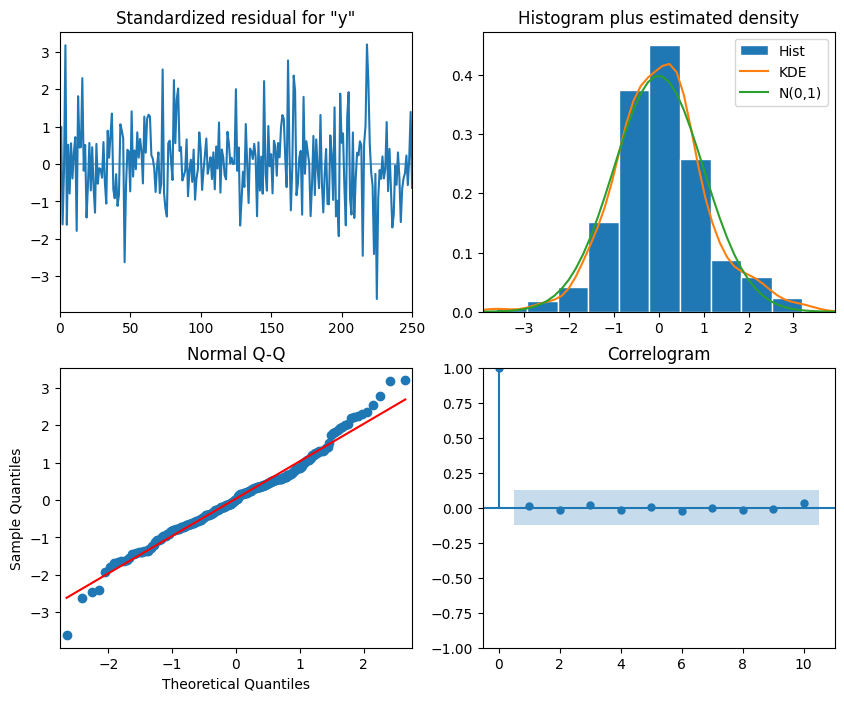

In [20]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [21]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.427411
  2     0.424154
  3     0.035653
  4     0.071238
  5     0.073972
  6     0.012441
  7     0.008660
  8     0.013517
  9     0.010526
  10    0.013601
  11    0.022049
  12    0.034132
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(8)},
 'squared_residuals': {'p_values': 1     0.763990
  2     0.923675
  3     0.000213
  4     0.000112
  5     0.000265
  6     0.000239
  7     0.000514
  8     0.000513
  9     0.001005
  10    0.001850
  11    0.001691
  12    0.002950
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(10)}}

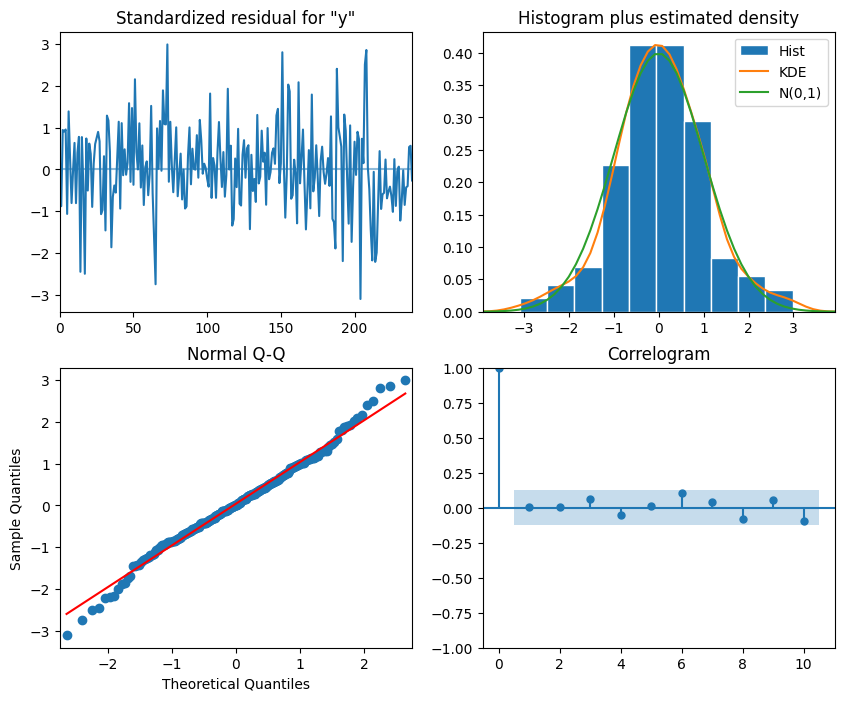

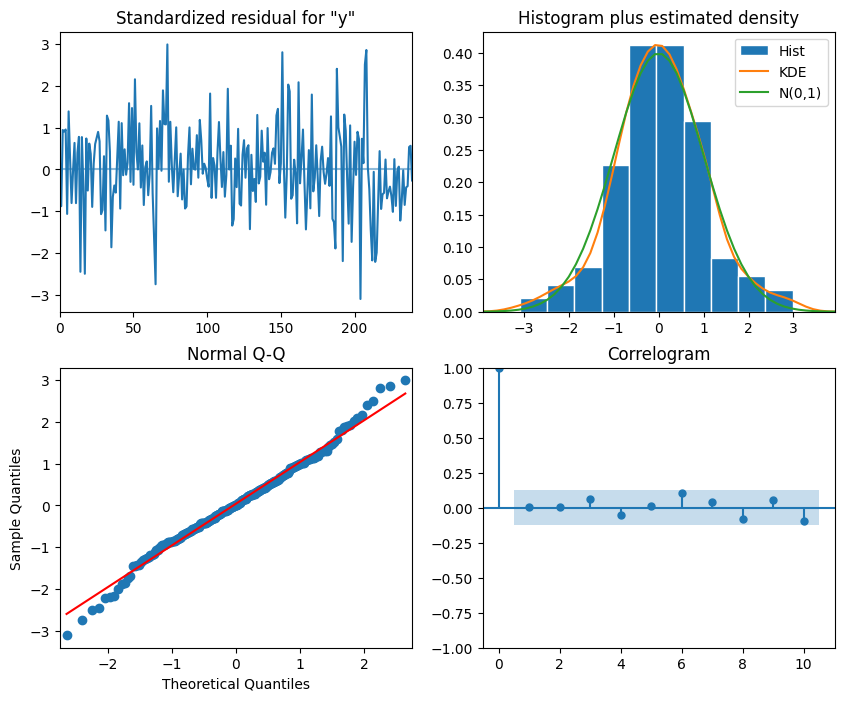

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_10[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add')
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.310601,0.383300,0.288309,0.295365,0.294322,0.275720,0.275655
253,0.333247,0.353654,0.288309,0.279315,0.308974,0.276735,0.276554
254,0.314364,0.346898,0.288309,0.302320,0.324790,0.277751,0.277452
255,0.353173,0.301097,0.288309,0.312862,0.318075,0.278768,0.278350
256,0.335864,0.260986,0.288309,0.294642,0.327409,0.279785,0.279249
257,0.380008,0.252757,0.288309,0.324830,0.315949,0.280803,0.280147
258,0.380612,0.264373,0.288309,0.320247,0.328035,0.281822,0.281046
259,0.372696,0.233635,0.288309,0.306324,0.303222,0.282842,0.281944
260,0.398696,0.230483,0.288309,0.328740,0.360434,0.283863,0.282843
261,0.376591,0.265664,0.288309,0.325041,0.349995,0.284885,0.283741


In [24]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     4.859168e-01
2     7.709753e-01
3     1.025021e-07
4     1.154833e-07
5     3.677550e-07
6     5.007723e-08
7     2.354763e-08
8     3.837049e-08
9     6.555277e-09
10    1.061453e-10
11    2.794375e-10
12    6.941861e-10
13    1.303101e-10
14    1.262346e-11
15    1.927344e-11
16    4.510432e-12
17    7.988669e-14
18    1.331451e-13
19    2.763579e-13
20    4.650394e-15
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(18)}, 'squared_residuals': {'p_values': 1     0.085261
2     0.200005
3     0.101742
4     0.048296
5     0.076054
6     0.056673
7     0.078550
8     0.101784
9     0.109689
10    0.025717
11    0.002551
12    0.003987
13    0.004675
14    0.004913
15    0.005724
16    0.008769
17    0.012255
18    0.018039
19    0.017278
20    0.015736
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(12)}}


In [25]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.424
Optimized:,True,AIC,-1601.720
Trend:,Additive,BIC,-1587.603
Seasonal:,None,AICC,-1601.378
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:58:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6201518,alpha,True
smoothing_trend,1.9522e-15,beta,True


## Theta

In [26]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:58:22   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0019124579827803413
alpha    0.6196979040810048
---------------------------
Forecast: 252    0.236363
253    0.244098
254    0.255092
255    0.249843
256    0.258767
257    0.259372
258    0.259465
259    0.265867
260    0.261891
261    0.255959
262    0.257627
263    0.250429
Name: forecast, dtype: float64


## Visualização das predições


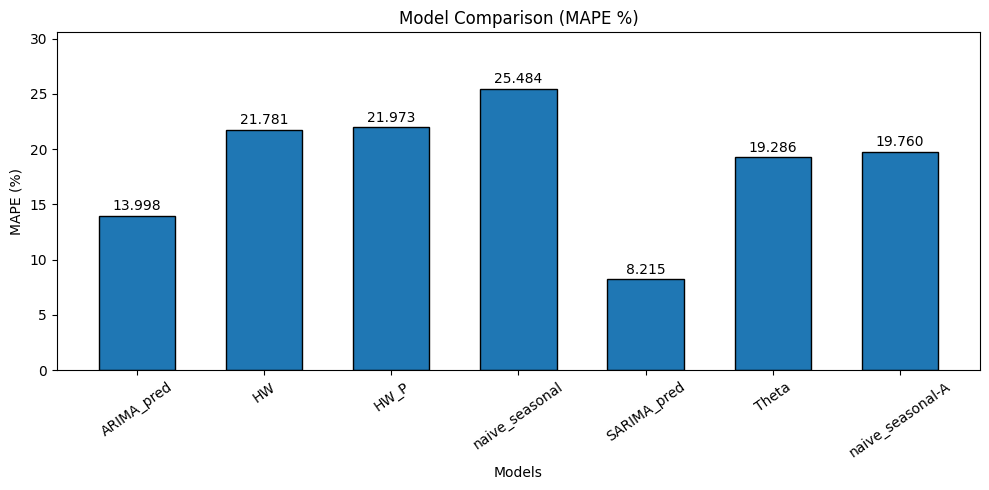

{'ARIMA_pred': np.float64(13.997762315915704),
 'HW': np.float64(21.781095806868088),
 'HW_P': np.float64(21.972865254360855),
 'naive_seasonal': np.float64(25.48400070852706),
 'SARIMA_pred': np.float64(8.215353009264527),
 'Theta': np.float64(19.286347533439827),
 'naive_seasonal-A': np.float64(19.7595182415043)}

In [27]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [28]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.310601,0.383300,0.288309,0.295365,0.294322,0.275720,0.275655,0.267144
253,0.333247,0.353654,0.288309,0.279315,0.308974,0.276735,0.276554,0.277018
254,0.314364,0.346898,0.288309,0.302320,0.324790,0.277751,0.277452,0.291185
255,0.353173,0.301097,0.288309,0.312862,0.318075,0.278768,0.278350,0.284402
256,0.335864,0.260986,0.288309,0.294642,0.327409,0.279785,0.279249,0.295958
257,0.380008,0.252757,0.288309,0.324830,0.315949,0.280803,0.280147,0.296744
258,0.380612,0.264373,0.288309,0.320247,0.328035,0.281822,0.281046,0.296866
259,0.372696,0.233635,0.288309,0.306324,0.303222,0.282842,0.281944,0.305227
260,0.398696,0.230483,0.288309,0.328740,0.360434,0.283863,0.282843,0.300028
261,0.376591,0.265664,0.288309,0.325041,0.349995,0.284885,0.283741,0.292310


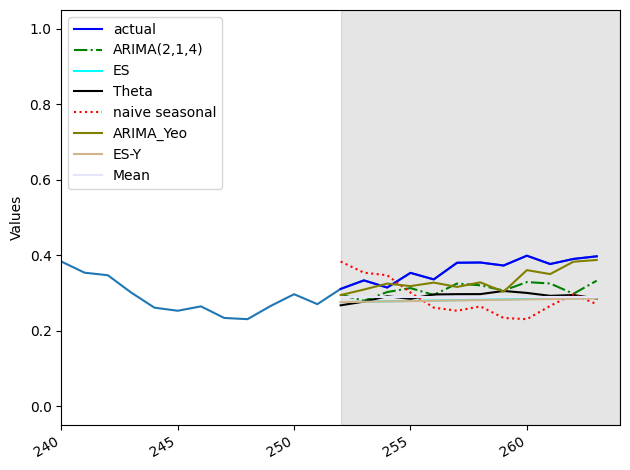

In [29]:
fig, ax = plt.subplots()

ax.plot(serie_10)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

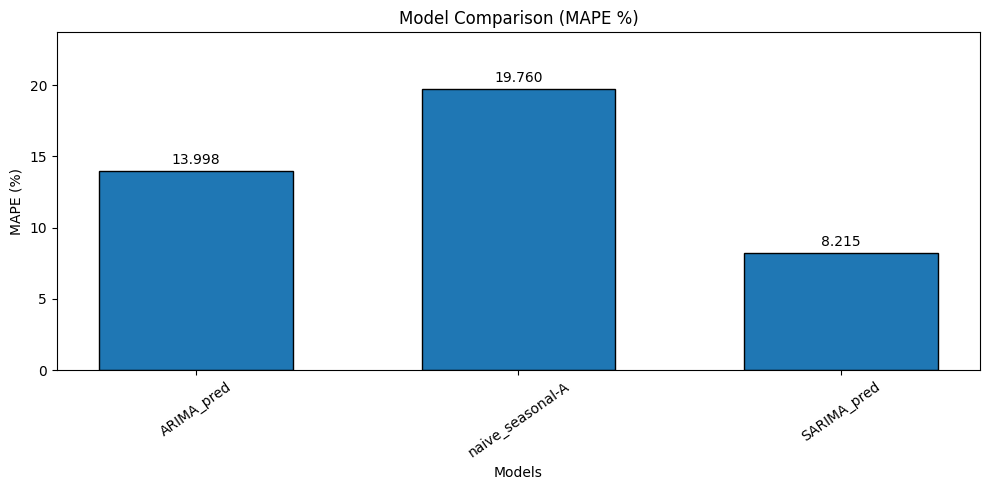

{'ARIMA_pred': np.float64(13.997762315915704),
 'naive_seasonal-A': np.float64(19.7595182415043),
 'SARIMA_pred': np.float64(8.215353009264527)}

In [30]:
columns = ['ARIMA_pred','naive_seasonal-A','SARIMA_pred']
plot_model_mape(test,'Values',columns)

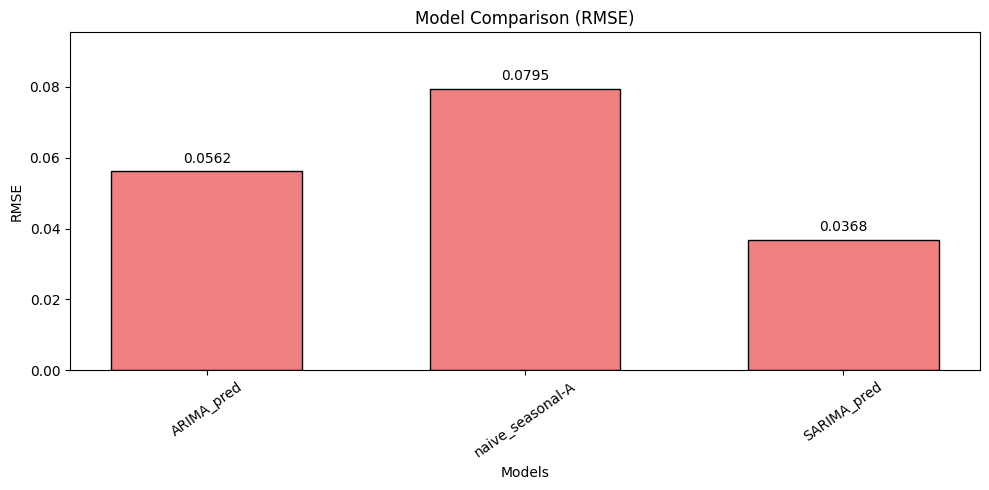

In [31]:
columns_to_plot = ['ARIMA_pred','naive_seasonal-A','SARIMA_pred']
rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [32]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_10.values.reshape(-1, 1)).flatten(), index=serie_10.index)


SARIMA_model = SARIMAX(train_transformed, order=(1,0,3), seasonal_order=(4,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

forecast_steps = 12
forecast_SARIMA = SARIMA_model_fit.forecast(steps=forecast_steps)

forecast_original_scale = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()

forecast_original_scale


array([0.36620718, 0.40099366, 0.44173961, 0.42426642, 0.44366666,
       0.46397124, 0.44016753, 0.44529538, 0.4825883 , 0.45256895,
       0.47959999, 0.48394147])

In [33]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast_original_scale)  # ou 11, se já definido

with open("10.csv", "w") as f:
    for i, value in enumerate(forecast_original_scale, 1):
        f.write(f"{value};\n")
